In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from sklearn.cluster import KMeans
import folium
# from arcgis.gis import GIS
# from arcgis.geometry import Point
# from arcgis.mapping import MapView
import sqlite3
# from sqlalchemy import create_engine, text

from sklearn.cluster import DBSCAN

# Truck Loading and Delivery Routes (TLDR)

Problem Statement:
    - Automate assigning customer orders to trucks.
    - Optimize truck routes to ensure they arrive at customers via the shortest path.

Data:
    - order
    - customer
    - product
    - truck

order:
    - Customer # : The unique identifier for each customer.
    - Invoice # : The unique identifier for each order.
    - Item # : The unique identifier for the product being ordered.
    - SalesQty : The quantity of the product ordered.

customer:
    - customerNo : The unique identifier for each customer.
    - Latitude : The geographical latitude of the customer's location.
    - Longitude : The geographical longitude of the customer's location.

product:
    - Item # : The unique identifier for the product.
    - Product Name : The name of the product.
    - Can Size (in mL) : The size of the product can in milliliters.
    - Can (in case) : Number of cans per case.
    - Packaging (carton) : Details about how the product is packaged in cartons.
    - Pallet Size (carton) : The size of the pallet containing cartons.
    - Cases per Pallet : The number of cases that fit on a pallet.
    - Gross Carton Weight (in Kg) : The weight of the carton in kilograms.
    - Carton Length (in cm) : The length of the carton in centimeters.
    - Carton Width (in cm) : The width of the carton in centimeters.
    - Carton Height (in cm) : The height of the carton in centimeters.

truck:
    - Truck ID : The unique identifier for each truck.
    - Truck Name : The name or model of the truck.
    - Capacity (Pallets) : The truck's carrying capacity in terms of pallets.
    - Multiple Trips (# of trips) : The number of trips the truck can make.
    - Priority : The priority level assigned to the truck for deliveries.

## Create Dataframes from csv files

In [ ]:
order = pd.read_csv("Orders.csv")
customer = pd.read_csv("Customer.csv")
product = pd.read_csv("Product.csv")
truck = pd.read_csv("Trucks.csv")

## Create Dataframes from csv files

In [ ]:
# Convert all 2nd row to columns for each table
tables = [order, customer, product, truck]

for table in tables:
    table.columns = table.iloc[1]
    # table = table.iloc[2:, :]
    table = table.drop([0,1], axis=0, inplace=True)

In [1]:
for table in tables:
    table.info()
    print("\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 2 to 1001
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Customer #  1000 non-null   object
 1   Invoice #   1000 non-null   object
 2   Item #      1000 non-null   object
 3   SalesQty    1000 non-null   object
dtypes: object(4)
memory usage: 31.4+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 2 to 57
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerNo  56 non-null     object
 1   Latitude    56 non-null     object
 2   Longitude   56 non-null     object
dtypes: object(3)
memory usage: 1.4+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 2 to 27
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Item #                         26 non-nul

### Convert all float text to real float

In [ ]:
char = "٫"
converter = lambda c: c.replace(char, ".")

for i in [1, 2]:
    customer[customer.columns[i]] = customer[customer.columns[i]].apply(converter).apply(float)

for i in [7, 8, 10]:
    product[product.columns[i]] = product[product.columns[i]].apply(converter).apply(float)

In [2]:
# print(order.head(5))
# print(product.head(5))
# print(customer.head(5))
print(truck.head(5))

1 Truck ID Truck Name Capacity (Pallets) Multiple Trips\n(# of trips) Priority
2        1  TruckA8 1                  8                            3        8
3        2  TruckB6 1                  6                            2        1
4        3  TruckB6 2                  6                            2        2
5        4  TruckB6 3                  6                            2        3
6        5  TruckB6 4                  6                            2        4


## Create SQLite3 Databse

In [3]:
def create_sqlite_database(filename):
    """ create a database connection to an SQLite database """
    conn = None
    try:
        conn = sqlite3.connect(filename)
        print(sqlite3.sqlite_version)
    except sqlite3.Error as e:
        print(e)
    finally:
        if conn:
            conn.close()


create_sqlite_database("database.db")

3.46.1


Convert Dataframes to SQLite
docs: 
    - https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_sql.html
    - https://www.sqlitetutorial.net/sqlite-python/creating-database/

In [ ]:
# database_file = f'sqlite://{os.getcwd()}/database.db'
# engine = create_engine(database_file, echo=False)

In [4]:
with sqlite3.connect("database.db") as conn:
    customer.to_sql('customer', con=conn, index=False)
    order.to_sql('order', con=conn, index=False)
    product.to_sql('product', con=conn, index=False)
    truck.to_sql('truck', con=conn, index=False)

---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
Cell In[20], line 2
      1 with sqlite3.connect("database.db") as conn:
----> 2     customer.to_sql('customer', con=conn, index=False)
      3     order.to_sql('order', con=conn, index=False)
      4     product.to_sql('product', con=conn, index=False)

File ~/.local/lib/python3.12/site-packages/pandas/util/_decorators.py:333, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    327 if len(args) > num_allow_args:
    328     warnings.warn(
    329         msg.format(arguments=_format_argument_list(allow_args)),
    330         FutureWarning,
    331         stacklevel=find_stack_level(),
    332     )
--> 333 return func(*args, **kwargs)

File ~/.local/lib/python3.12/site-packages/pandas/core/generic.py:3087, in NDFrame.to_sql(self, name, con, schema, if_exists, index, index_label, chunksize, dtype,

In [5]:
with sqlite3.connect("database.db") as conn:
    print(conn.execute("SELECT * FROM product").fetchall())

[('CSD-11100101', 'Lift Up', '250', '30 Can', 'Case', '100 x 120', '144', 8.3, 32.5, '27', 11.8), ('CSD-11100102', 'KINZA COLA', '360', '24 Can', 'Case', '100 x 120', '130', 9.5, 40.2, '27', 12.45), ('CSD-11100103', 'KINZA COLA', '250', '30 Can', 'Case', '100 x 120', '144', 8.3, 32.5, '27', 11.8), ('CSD-11100104', 'KINZA COLA', '185', '30 Can', 'Case', '100 x 120', '192', 6.15, 32.5, '27', 11.8), ('CSD-11100105', 'KINZA Orange', '360', '24 Can', 'Case', '100 x 120', '130', 9.5, 40.2, '27', 11.8), ('CSD-11100106', 'KINZA Orange', '250', '30 Can', 'Case', '100 x 120', '144', 8.3, 32.5, '27', 11.8), ('CSD-11100107', 'KINZA Orange', '185', '30 Can', 'Case', '100 x 120', '192', 6.15, 32.5, '27', 11.8), ('CSD-11100108', 'KINZA CITRUS', '360', '24 Can', 'Case', '100 x 120', '130', 9.5, 40.2, '27', 11.8), ('CSD-11100109', 'KINZA CITRUS', '250', '30 Can', 'Case', '100 x 120', '144', 8.3, 32.5, '27', 11.8), ('CSD-11100110', 'KINZA CITRUS', '185', '30 Can', 'Case', '100 x 120', '192', 6.15, 32.5,

### Visualize Customer Locations in grid

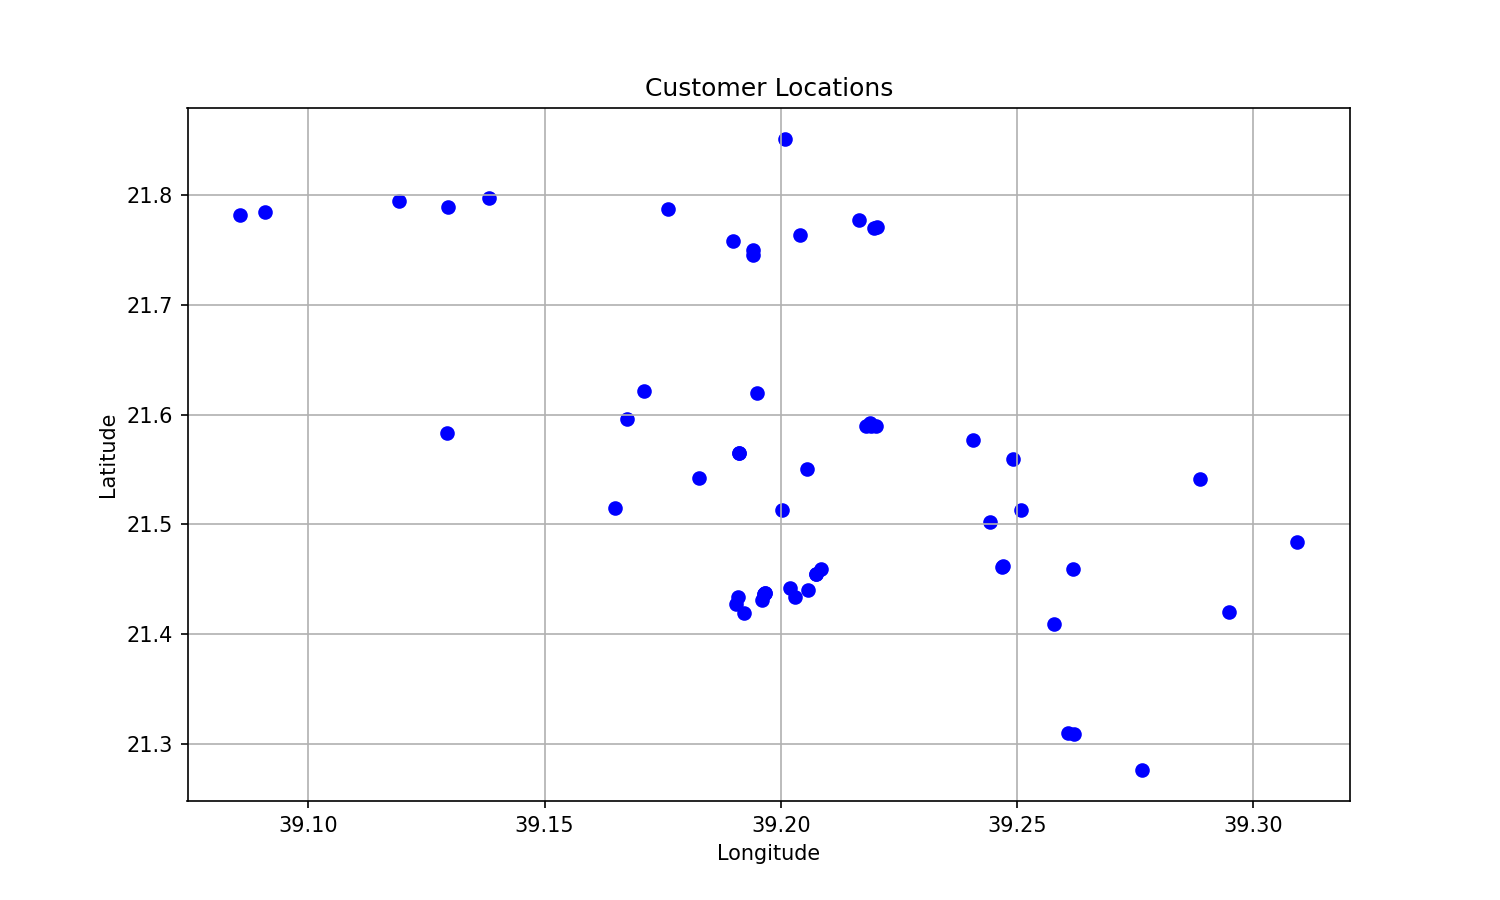

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(customer['Longitude'], customer['Latitude'], c='blue', marker='o')

plt.title('Customer Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

plt.show()

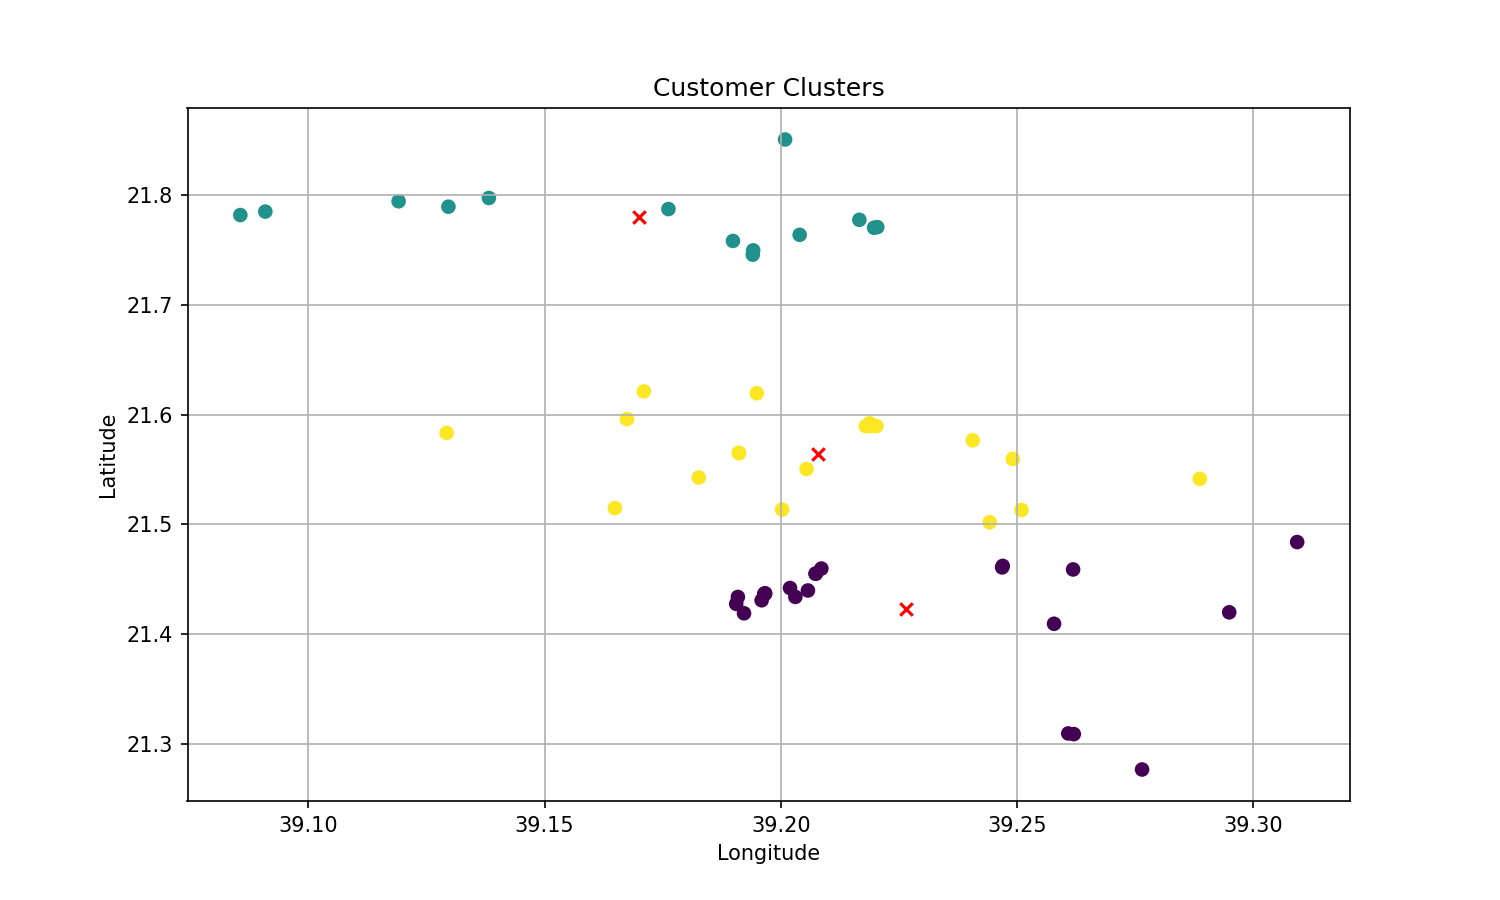

In [7]:
# Prepare the data for clustering
coordinates = np.array(list(zip(customer['Latitude'], customer['Longitude'])))

# Perform KMeans clustering (e.g., 3 clusters)
kmeans = KMeans(n_clusters=3)
kmeans.fit(coordinates)
labels = kmeans.labels_

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(customer['Longitude'], customer['Latitude'], c=labels, cmap='viridis', marker='o')

# Add cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='red', marker='x')

# Add labels and title
plt.title('Customer Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

# Show the plot
plt.show()

In [8]:
target_customer = (21.501795, 39.24419833)
distances = []

for lat, lon in zip(customer['Latitude'], customer['Longitude']):
    distance = geodesic(target_customer, (lat, lon)).kilometers
    distances.append(distance)

# Get the index of the nearest neighbor (excluding the customer itself)
nearest_index = distances.index(sorted(distances)[1])  # [1] to skip the zero distance to itself
nearest_customer_no = customer['customerNo'][nearest_index]

print(f'The nearest customer to 102215 is: {nearest_customer_no}')

The nearest customer to 102215 is: 102100


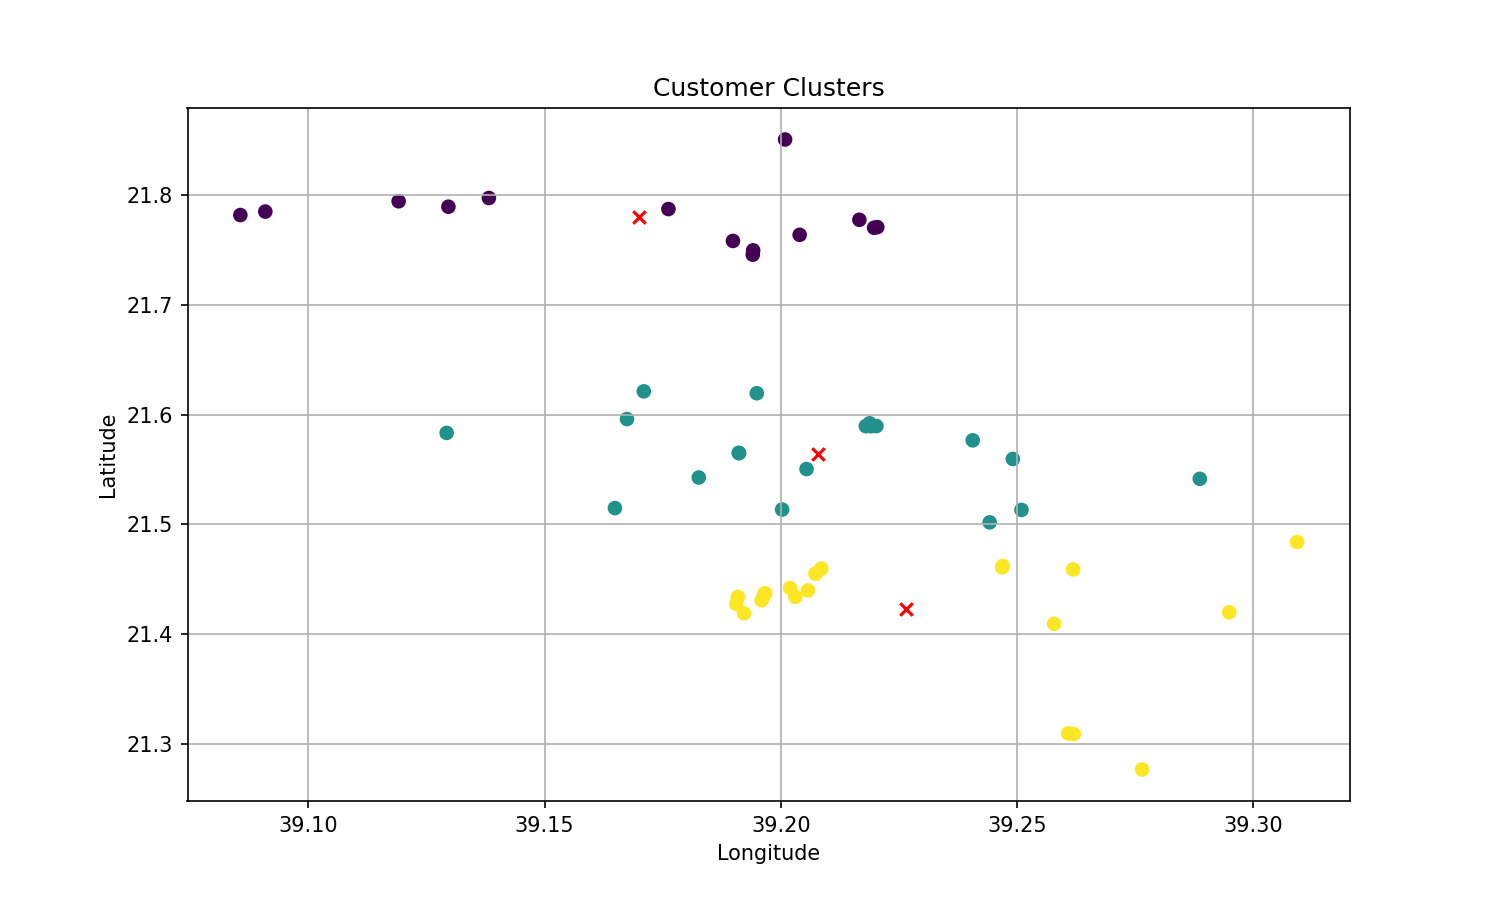

In [9]:
# Prepare the data for clustering
coordinates = np.array(list(zip(customer['Latitude'], customer['Longitude'])))

# Perform KMeans clustering (e.g., 3 clusters)
kmeans = KMeans(n_clusters=3)
kmeans.fit(coordinates)
labels = kmeans.labels_

# Plot the clusters
plt.figure(figsize=(10, 6))
plt.scatter(customer['Longitude'], customer['Latitude'], c=labels, cmap='viridis', marker='o')

# Add cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 1], centers[:, 0], c='red', marker='x')

# Add labels and title
plt.title('Customer Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

# Show the plot
plt.show()

Visualize Customer Locations in map

In [ ]:
# Create a map centered around the average latitude and longitude
center_lat = sum(customer['Latitude']) / len(customer['Latitude'])
center_lon = sum(customer['Longitude']) / len(customer['Longitude'])
map_customers = folium.Map(location=[center_lat, center_lon], zoom_start=11, tiles='OpenStreetMap')

In [ ]:
# Add Esri World Imagery basemap
esri_tiles = folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Esri World Imagery',
    overlay=True,
    control=True
)

esri_tiles.add_to(map_customers)

# Add Google Maps tile layer (optional; this uses a plugin and does not need an API key)
folium.TileLayer('https://mt1.google.com/vt/lyrs=r&x={x}&y={y}&z={z}', 
                 attr='Google', name='Google Maps', overlay=True).add_to(map_customers)

# Add layer control
# folium.LayerControl().add_to(map_customers)

# Add customer markers to the map
for lat, lon, cust_no in zip(customer['Latitude'], customer['Longitude'], customer['customerNo']):
    folium.Marker(
        location=[lat, lon],
        popup=f'Customer No: {cust_no}',
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(map_customers)

# Add layer control
folium.LayerControl().add_to(map_customers)

# Save the map to an HTML file
map_customers.save('esri_google_maps_OpenStreetMap_customers.html')

In [10]:
# Authenticate with ArcGIS Online (requires an account)
gis = GIS("home")

# Create a map centered around the average latitude and longitude
map_view = gis.map(location=[center_lat, center_lon], zoomlevel=11)

# Add customer locations as graphics
for lat, lon, cust_no in zip(customer_data['Latitude'], customer_data['Longitude'], customer_data['customerNo']):
    point = Point({"x": lon, "y": lat})
    map_view.draw(point, popup={"title": f"Customer No: {cust_no}"})

# Display the map
map_view

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
Cell In[231], line 2
      1 # Authenticate with ArcGIS Online (requires an account)
----> 2 gis = GIS("home")
      4 # Create a map centered around the average latitude and longitude
      5 map_view = gis.map(location=[center_lat, center_lon], zoomlevel=11)

NameError: name 'GIS' is not defined


## K-means with real map

In [ ]:
# Extract latitude and longitude
coordinates = customer[['Latitude', 'Longitude']]

# Perform K-Means clustering
num_clusters = 10  # You can adjust the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
customer['Cluster'] = kmeans.fit_predict(coordinates)

# Create a folium map centered around the average location
center_lat = customer['Latitude'].mean()
center_lon = customer['Longitude'].mean()
map_clusters = folium.Map(location=[center_lat, center_lon], zoom_start=11, tiles=None)

# Add Esri World Imagery basemap
esri_tiles = folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Esri World Imagery',
    overlay=True,
    control=True
)
esri_tiles.add_to(map_clusters)

# Define colors for clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen']

# Add customer markers to the map, color-coded by cluster
for _, row in customer.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f'Customer No: {row["customerNo"]}, Cluster: {row["Cluster"]}',
        icon=folium.Icon(color=colors[row['Cluster'] % len(colors)], icon='info-sign')
    ).add_to(map_clusters)

# Add layer control
folium.LayerControl().add_to(map_clusters)

# Save the map to an HTML file
map_clusters.save('customer_clusters_map.html')

## DBSCAN with real map

In [ ]:
# Convert latitude and longitude to radians for haversine distance calculation
coords = np.radians(customer[['Latitude', 'Longitude']])

# Set the maximum distance (in kilometers) for clustering
eps_km = 5  # Adjust this value to set the clustering range in kilometers

# Earth radius in kilometers
earth_radius_km = 300.0

# Perform DBSCAN clustering
db = DBSCAN(eps=eps_km / earth_radius_km, min_samples=2, metric='haversine').fit(coords)
customer['Cluster'] = db.labels_

# Create a folium map centered around the average location
center_lat = customer['Latitude'].mean()
center_lon = customer['Longitude'].mean()
map_clusters = folium.Map(location=[center_lat, center_lon], zoom_start=11, tiles='OpenStreetMap')

# Define colors for clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen']

# Add customer markers to the map, color-coded by cluster
for _, row in customer.iterrows():
    cluster_id = row['Cluster']
    color = 'gray' if cluster_id == -1 else colors[cluster_id % len(colors)]  # Use gray for noise points (cluster ID -1)
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f'Customer No: {row["customerNo"]}, Cluster: {cluster_id}',
        icon=folium.Icon(color=color, icon='info-sign')
    ).add_to(map_clusters)

# Add layer control
folium.LayerControl().add_to(map_clusters)

# Save the map to an HTML file
map_clusters.save('customer_clusters_map_km.html')

In [ ]:
customer_orders = customer.merge(order, how="inner",  left_on=customer.columns[0], right_on=order.columns[0])
customer_orders.drop(order.columns[0], axis=1, inplace=True)

In [11]:
# customer_orders.columns[4]

'Item #'

In [12]:
customer_orders.merge(
        product, how="inner",
        left_on=customer_orders.columns[4],
        right_on=product.columns[0]
        )

1   customerNo     Latitude    Longitude  ... Carton Length  \n(in cm) Carton Width  \n(in cm) Carton  Height \n(in cm)
0       102215    21٫501795  39٫24419833  ...                     32٫5                      27                     11٫8
1       102215    21٫501795  39٫24419833  ...                     32٫5                      27                     11٫8
2       102215    21٫501795  39٫24419833  ...                     32٫5                      27                     11٫8
3       102215    21٫501795  39٫24419833  ...                     32٫5                      27                     11٫8
4       102215    21٫501795  39٫24419833  ...                     32٫5                      27                     11٫8
..         ...          ...          ...  ...                      ...                     ...                      ...
950     102854  21٫48383112   39٫3092635  ...                     32٫5                      27                     11٫8
951     102854  21٫48383112   39٫3092635